In [1]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
from warnings import simplefilter
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import r2_score
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

In [2]:
plt.style.use('Solarize_Light2')
simplefilter('ignore')

In [3]:
print(sm.datasets.sunspots.NOTE)

::

    Number of Observations - 309 (Annual 1700 - 2008)
    Number of Variables - 1
    Variable name definitions::

        SUNACTIVITY - Number of sunspots for each year

    The data file contains a 'YEAR' variable that is not returned by load.



In [4]:
dta = sm.datasets.sunspots.load_pandas().data

In [5]:
dta.index = pd.Index(sm.tsa.datetools.dates_from_range("1700", "2008"))
dta.index.freq = dta.index.inferred_freq
del dta["YEAR"]

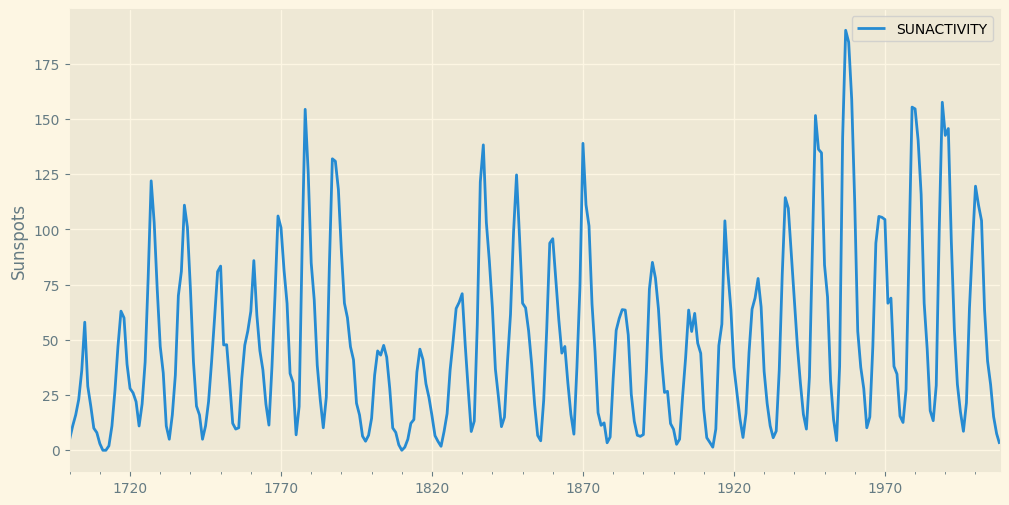

In [6]:
fig, ax = plt.subplots(figsize=(12, 6))  
dta.plot(ax=ax)  
ax.set_ylabel('Sunspots')
plt.show()

In [7]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(dta['SUNACTIVITY'])
print(result)

(-2.8377807249381966, 0.05307642172812041, 8, 300, {'1%': -3.4523371197407404, '5%': -2.871222860740741, '10%': -2.571929211111111}, 2430.50034229055)


In [8]:
pvalue = result[1]

In [9]:
if pvalue < 0.05:
    print('stationary')
else:
    print('not stationary')

not stationary


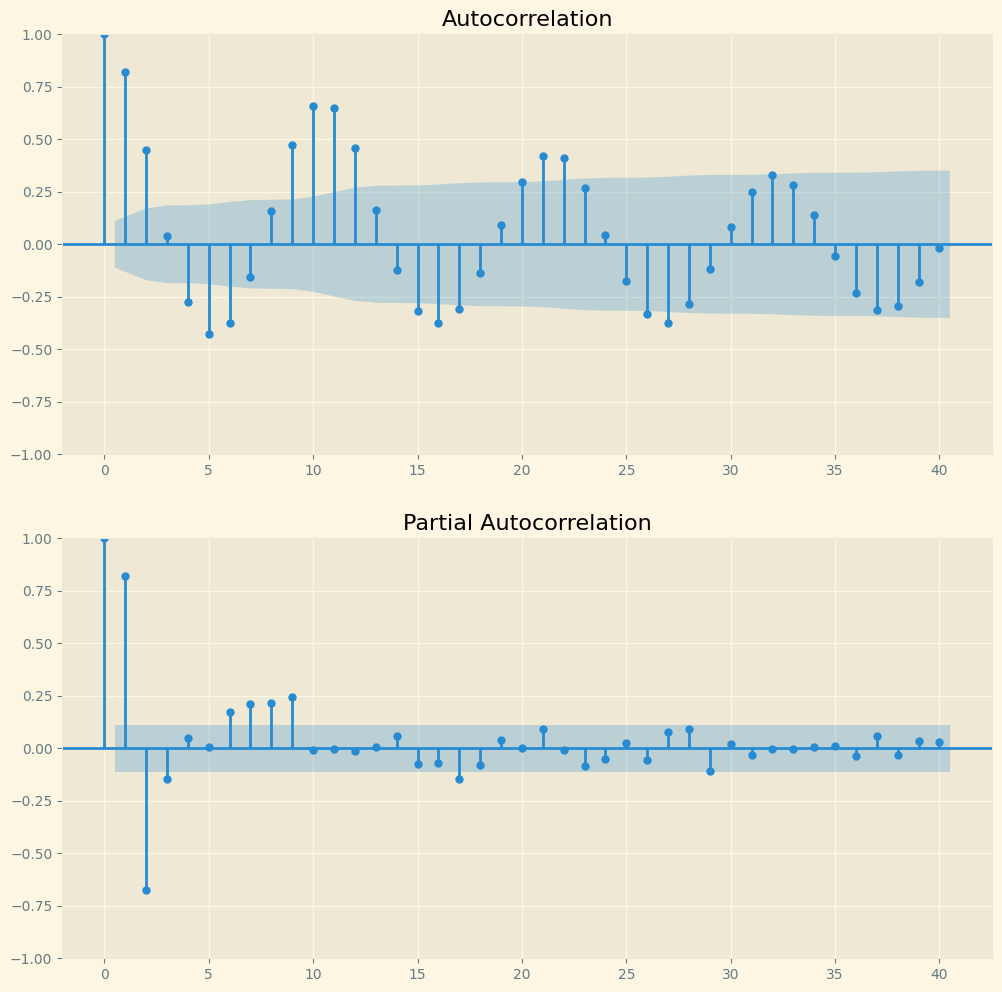

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12)) 

plot_acf(dta['SUNACTIVITY'], lags=40, ax=ax1)  
plot_pacf(dta['SUNACTIVITY'], lags=40, ax=ax2)  
plt.show()

In [11]:
mod = ARIMA(list(dta['SUNACTIVITY']), order=(1, 0, 1))
res = mod.fit()
pred = res.predict()

print(r2_score(dta, pred))

0.7707182068126296


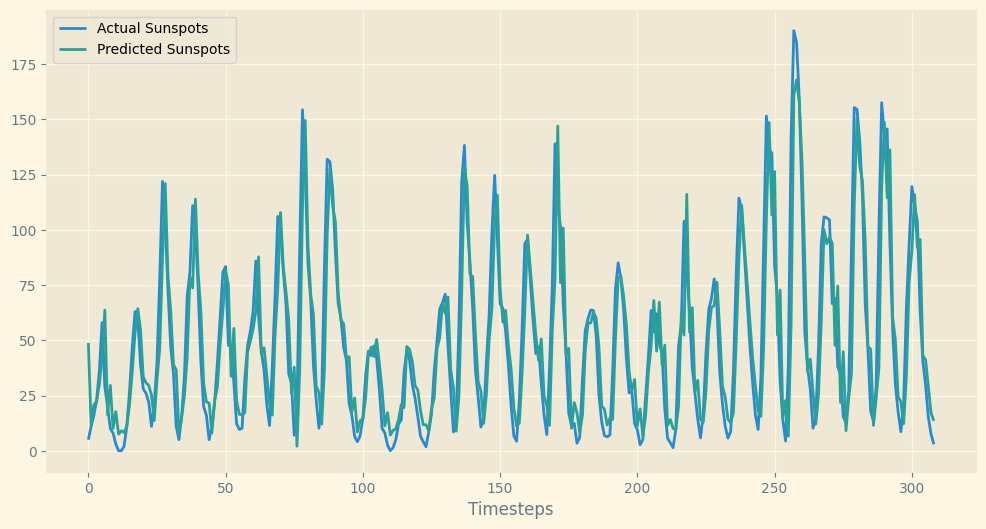

In [12]:
plt.figure(figsize=(12,6))
plt.plot(list(dta['SUNACTIVITY']))
plt.plot(pred)
plt.legend(['Actual Sunspots', 'Predicted Sunspots'])
plt.xlabel('Timesteps')
plt.show()

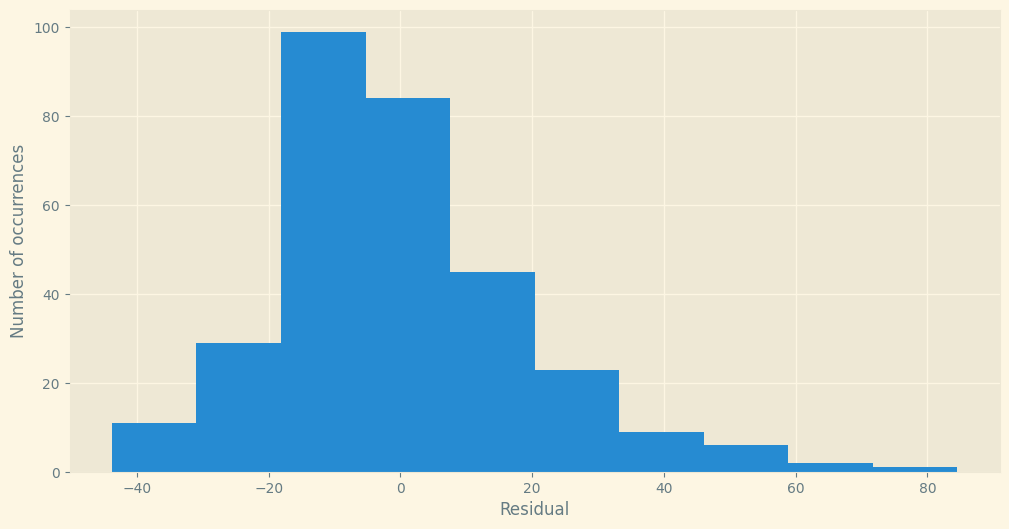

In [13]:
plt.figure(figsize=(12,6))
ax = pd.Series(res.resid).hist()
ax.set_ylabel('Number of occurrences')
ax.set_xlabel('Residual')
plt.show()

In [14]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  309
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1352.613
Date:                Tue, 06 May 2025   AIC                           2713.226
Time:                        11:40:43   BIC                           2728.160
Sample:                             0   HQIC                          2719.197
                                - 309                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         48.7921      8.077      6.041      0.000      32.962      64.623
ar.L1          0.7355      0.046     15.921      0.000       0.645       0.826
ma.L1          0.5194      0.048     10.798      0.000       0.425       0.614
sigma2       369.1788     25.783     14.319      0.000     318.646     419.712
===================================================================================
Ljung-Box (L1) (Q):                   9.89   Jarque-Bera (JB):                73.24
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.93   Skew:                             0.89
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
data_array = dta.values
avg_errors = []

for p in range(2):
    for q in range(2):
        errors = []
        tscv = TimeSeriesSplit(test_size=10)
        for train_index, test_index in tscv.split(data_array):
            x_train, x_test = data_array[train_index], data_array[test_index]
            x_test_orig = x_test

            fcst = []
            for step in range(10):
                try:
                    mod = ARIMA(x_train, order=(p, 0, q))
                    res = mod.fit()
                    fcst.append(res.forecast(steps=1))
                except:
                    print("errored")
                    fcst.append(-9999999.0)
                x_train = np.concatenate((x_train, x_test[0:1, :]))
                x_test = x_test[1:]
            errors.append(r2_score(x_test_orig, fcst))
        pq_result = [p, q, np.mean(errors)]
        print(pq_result)
        avg_errors.append(pq_result)

[0, 0, -0.19537571789500857]
[0, 1, 0.5148074126202729]
[1, 0, 0.6258570123912045]
[1, 1, 0.7165957003944337]


In [16]:
avg_errors = pd.DataFrame(avg_errors)
avg_errors.columns = ['p', 'q', 'error']
result = avg_errors.pivot(index='p', columns='q')

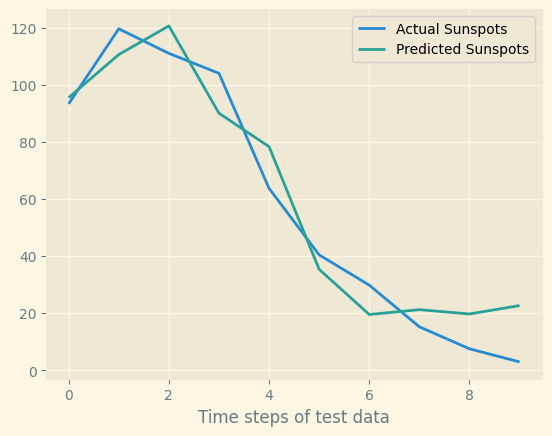

In [17]:
dta_array = dta.values
x_train, x_test = dta_array[:-10], dta_array[-10:]
x_test_orig = x_test

fcst = []
for step in range(10):
    mod = ARIMA(x_train, order=(10, 0, 9))
    res = mod.fit()
    fcst.append(res.forecast(steps=1))
    x_train = np.concatenate((x_train, x_test[0:1, :]))
    x_test = x_test[1:]

plt.plot(x_test_orig)
plt.plot(fcst)
plt.legend(['Actual Sunspots', 'Predicted Sunspots'])
plt.xlabel('Time steps of test data')
plt.show()

In [18]:
dta

,SUNACTIVITY
1700-12-31,5.0
1701-12-31,11.0
1702-12-31,16.0
1703-12-31,23.0
1704-12-31,36.0
...,...
2004-12-31,40.4
2005-12-31,29.8
2006-12-31,15.2
2007-12-31,7.5


In [33]:
model = ARIMA(dta[:300],order=(10,0,9)).fit()
y = model.forecast(10)

In [34]:
y

2000-12-31    110.570859
2001-12-31    110.330299
2002-12-31     91.273069
2003-12-31     68.525240
2004-12-31     42.791787
2005-12-31     21.973304
2006-12-31     13.008067
2007-12-31     17.035115
2008-12-31     36.713300
2009-12-31     61.301839
Freq: YE-DEC, Name: predicted_mean, dtype: float64

<Axes: ylabel='predicted_mean'>

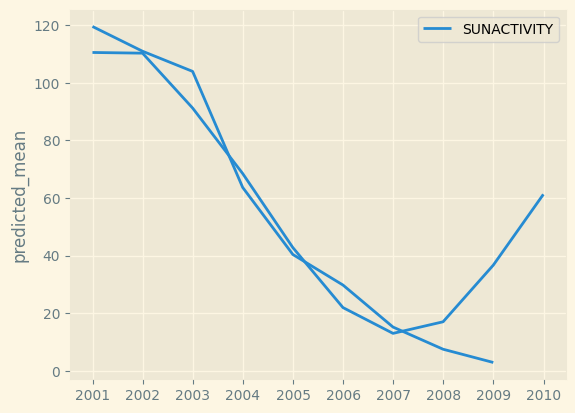

In [35]:
import seaborn as sns
sns.lineplot(y)
sns.lineplot(dta[300:310])

In [ ]:
dta_array = dta.values
x_train, x_test = dta_array[:-10], dta_array[-10:]
x_test_orig = x_test

fcst = []
for step in range(10):
    mod = ARIMA(x_train, order=(10, 0, 9))
    res = mod.fit()
    fcst.append(res.forecast(steps=1))
    x_train = np.concatenate((x_train, x_test[0:1, :]))
    x_test = x_test[1:]

plt.plot(x_test_orig)
plt.plot(fcst)
plt.legend(['Actual Sunspots', 'Predicted Sunspots'])
plt.xlabel('Time steps of test data')
plt.show()